## Setup

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3,ResNet152V2, Xception, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.7.0
• GPU Device Found.


## Read the processed data into the training dataset and validation dataset
The data in this directory has been previously cleaned, which finally obtained a dataset of 500 images in each class which is divided into 3 directories in the training directory as much as 80% or 400 images in each class, the Validation data as much as 10% or 100 images in each class, and the test data as much as 10% or 100 images in each class.

In [3]:
TRAINING_DIR = "Dataset_fix/train_dir/"
VALIDATION_DIR = "Dataset_fix/validation_dir/"
TEST_DIR = "Dataset_fix/test_dir/"

In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    train_datagen = ImageDataGenerator(rescale= 1./255.,
                                        rotation_range=45,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,             
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        color_mode='rgb',
                                                        class_mode="categorical",
                                                        target_size=(299, 299))

    
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  color_mode='rgb',
                                                                  class_mode="categorical",
                                                                  target_size=(299, 299))
    
    test_datagen = ImageDataGenerator(rescale=1./255.)
    
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      color_mode='rgb',
                                                      batch_size=32,
                                                      class_mode="categorical",
                                                      target_size=(299, 299))
    
    return train_generator, validation_generator, test_generator

In [5]:
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 8000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.


In [6]:
label_names = list(validation_generator.class_indices.keys())
print(f"{label_names} \nClass : {len(label_names)}")

['American_shorthair', 'Basset_hound', 'Beagle', 'Bengal', 'Boxer', 'British_Shorthair', 'Chihuahua', 'English_cocker_spaniel', 'Japanese_chin', 'Maine_Coon', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian_Blue', 'Samoyed', 'Scottish_fold', 'Siamese', 'Sphynx'] 
Class : 20


In [7]:
def plotImages(images_arr, folder_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, folder_name, ax in zip(images_arr, folder_names, axes):
        ax.imshow(img[:, :, 0])
        ax.axis('off')
        ax.set_title(folder_name)
    plt.tight_layout()
    plt.show()

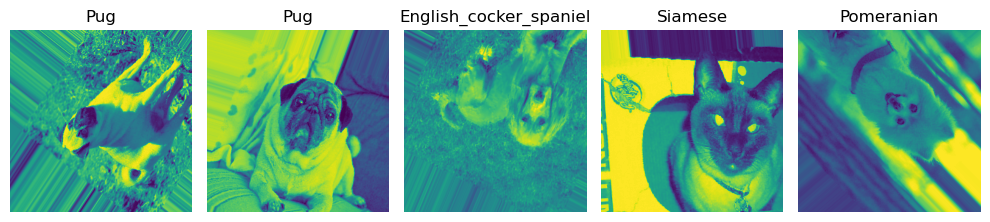

In [8]:
sample_training_images, labels = next(train_generator)
folder_names = [list(train_generator.class_indices.keys())[label.argmax()] for label in labels]

plotImages(sample_training_images[:5], folder_names)

## Creating a Callback class

In [9]:
callbacks = EarlyStopping(patience=10,
                          min_delta=0.001,
                          baseline=None,
                          mode='max',
                          monitor='val_accuracy',
                          restore_best_weights=True,
                          verbose=1
                         )

## Define, compile and Train the model

In [10]:
pre_trained_model = InceptionV3(input_shape = (299, 299, 3), 
                                include_top = False)

for layer in pre_trained_model.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 24s 0us/step


In [11]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [12]:
model = tf.keras.Sequential([
        pre_trained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),     
        tf.keras.layers.Dense(20,activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 88,980,404
Trainable params: 67,177,620
No

In [14]:
# Train the model
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                   )

Epoch 1/50
250/250 [==============================] - 178s 670ms/step - loss: 1.7284 - accuracy: 0.5091 - val_loss: 0.8220 - val_accuracy: 0.7420
Epoch 2/50
250/250 [==============================] - 150s 601ms/step - loss: 1.2236 - accuracy: 0.6230 - val_loss: 0.7598 - val_accuracy: 0.7480
Epoch 3/50
250/250 [==============================] - 148s 593ms/step - loss: 1.0967 - accuracy: 0.6520 - val_loss: 0.7527 - val_accuracy: 0.7530
Epoch 4/50
250/250 [==============================] - 149s 594ms/step - loss: 1.0249 - accuracy: 0.6751 - val_loss: 0.6396 - val_accuracy: 0.7890
Epoch 5/50
250/250 [==============================] - 148s 590ms/step - loss: 0.9785 - accuracy: 0.6771 - val_loss: 0.6496 - val_accuracy: 0.7910
Epoch 6/50
250/250 [==============================] - 149s 596ms/step - loss: 0.9490 - accuracy: 0.6915 - val_loss: 0.6735 - val_accuracy: 0.7800
Epoch 7/50
250/250 [==============================] - 148s 590ms/step - loss: 0.9178 - accuracy: 0.6999 - val_loss: 0.6626 -

### Training History

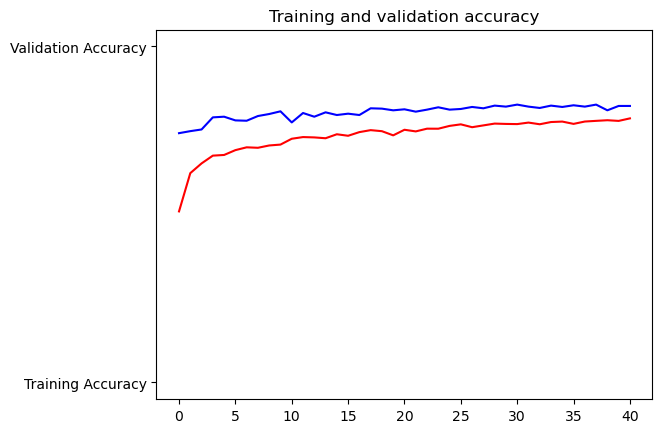

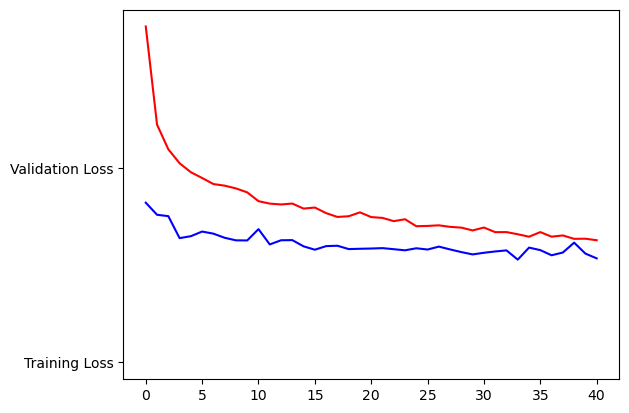

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### Fine tune

In [16]:
pre_trained_model.trainable = True

for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/50
250/250 [==============================] - 152s 599ms/step - loss: 0.6008 - accuracy: 0.7934 - val_loss: 0.5335 - val_accuracy: 0.8380
Epoch 2/50
250/250 [==============================] - 149s 596ms/step - loss: 0.5890 - accuracy: 0.8001 - val_loss: 0.5254 - val_accuracy: 0.8340
Epoch 3/50
250/250 [==============================] - 148s 592ms/step - loss: 0.5795 - accuracy: 0.8019 - val_loss: 0.5256 - val_accuracy: 0.8410
Epoch 4/50
250/250 [==============================] - 153s 611ms/step - loss: 0.5724 - accuracy: 0.8039 - val_loss: 0.5337 - val_accuracy: 0.8350
Epoch 5/50
250/250 [==============================] - 149s 597ms/step - loss: 0.5653 - accuracy: 0.8027 - val_loss: 0.5246 - val_accuracy: 0.8360
Epoch 6/50
250/250 [==============================] - 149s 595ms/step - loss: 0.5709 - accuracy: 0.8023 - val_loss: 0.5272 - val_accuracy: 0.8330
Epoch 7/50
250/250 [==============================] - 149s 596ms/step - loss: 0.5492 - accuracy: 0.8065 - val_loss: 0.5262 -

### Training History

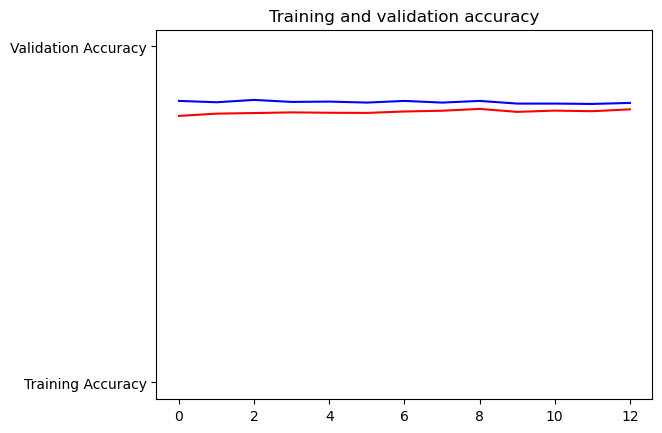

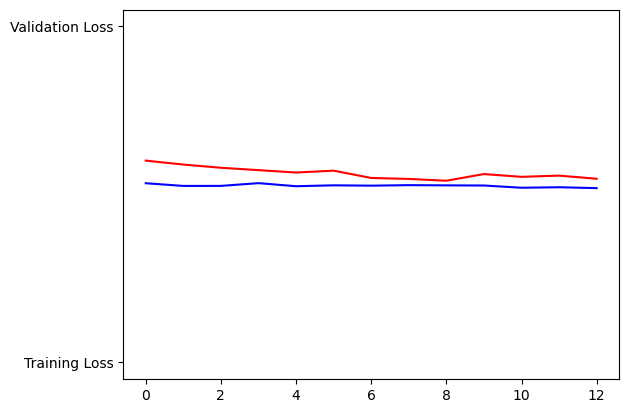

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### Evaluate the Model

In [18]:
# Evaluate the model on the test images.
results = model.evaluate(test_generator)

for metric, value in zip(model.metrics_names, results):
    print(metric + ': {:.3}'.format(value))

32/32 [==============================] - 6s 197ms/step - loss: 0.5429 - accuracy: 0.8100
loss: 0.543
accuracy: 0.81


### Testing models with images that have never been used

In [22]:
def load_and_prep_image(filename, img_shape=299):
    # Read in target file (an image)
    img = tf.io.read_file(filename)
    
    # Decode the read file into a tensor & ensure 3 colour channels 
    # our model is trained on images with 3 colour channels 
    img = tf.image.decode_image(img, channels=3)
    
    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img
     

In [23]:
def pred_and_plot(model, filename, label_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))
    indeks_kolom = tf.where(tf.round(pred)[0] == 1)
    pred_class = label_names[int(indeks_kolom)]
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

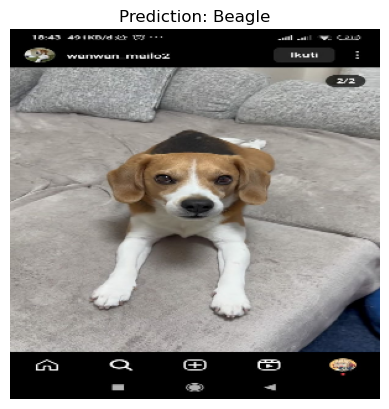

In [24]:
# Test our model on a custom image
pred_and_plot(model, "WhatsApp Image 2023-05-25 at 18.43.46.jpeg", label_names)

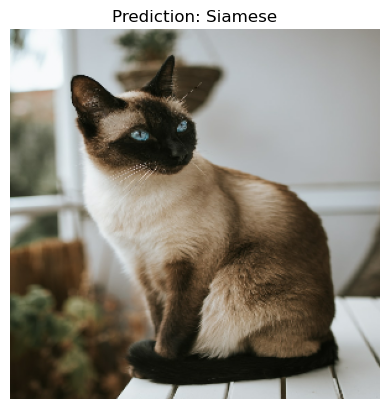

In [25]:
# Test our model on a custom image
pred_and_plot(model, "siamese_cat_2.jpg", label_names)

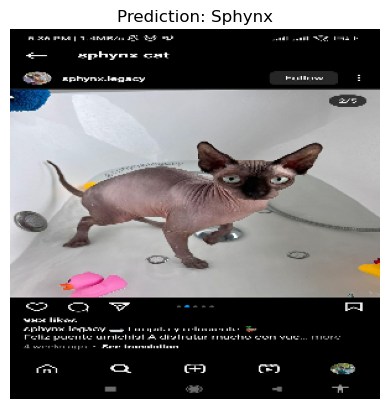

In [26]:
# Test our model on a custom image
pred_and_plot(model, "Screenshot_2023-05-26-17-36-11-408_com.instagram.android.jpg", label_names)

## save model format Keras HDF5

In [28]:
model.save('Inceptionv3_datafix.h5')

## Save model Exporting to TFLite

In [29]:
export_dir = 'saved_model/Inceptionv3_datafix'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/Inceptionv3_datafix\assets


In [30]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [32]:
tflite_model_file = pathlib.Path('./Inceptionv3_datafix.tflite')
tflite_model_file.write_bytes(tflite_model)

89410280